In [26]:
# This file generates the data for Figure #4 from the paper https://arxiv.org/pdf/1806.06975.pdf

In [1]:
import os 
os.chdir('..')

In [2]:
import pickle
import argparse
import networkx as nx
import pandas as pd
import numpy as np
import sklearn
import torch
import datetime
import matplotlib, matplotlib.pyplot as plt
from torch.autograd import Variable

from models.ml_methods import MLMethods
import data, data.gene_datasets


KeyboardInterrupt: 

In [ ]:
# Set the sample path depending on the location of your code and dataset.
# If it is unset, the TCGA dataset will be downloaded from Academic Torrents.
samples_path = ""


if samples_path:
    data_dir = '/'.join(samples_path.split('/')[:-1])
    data_file = samples_path.split('/')[-1]
    dataset = data.gene_datasets.TCGATissue(data_dir=data_dir, data_file=data_file)
else:
    dataset = data.gene_datasets.TCGATissue()

dataset.df = dataset.df - dataset.df.mean() # Make sure the dataset is normalized


In [ ]:
# On which graphs will we run this experiment? Parameterize this. 
# you will need to add your graph to AcademicTorrents and put the hash into the get_at_hash function in data/graph.py
# or simply pass the path directly into graph.load_graph() below.
graph_names = ["regnet", "genemania"]


graphs = {}
graph = data.graph.Graph()
for graph_name in graph_names:
    graph_hash_or_path = data.graph.get_at_hash(graph_name)
    graph.load_graph(graph_hash_or_path)
    nx_graph = nx.from_numpy_matrix(graph.adj)
    mapping = dict(zip(range(0, len(dataset.df.columns)), dataset.df.columns))
    nx_graph = nx.relabel_nodes(nx_graph, mapping)
    graphs[graph_name] = nx_graph


In [ ]:
# Setup the results dictionary
results_file_name = "experiments/results/fig-4/data.pkl"
try:
    results = pickle.load(open(results_file_name, "r"))
    print "Loaded Checkpointed Results"
    print ("Only " + str(dataset.df.shape[1] - len(results['df']['gene_name'].unique())) + " more genes to do...")
except Exception as e:
    results = {"df": pd.DataFrame(columns=['auc', 'gene_name', 'model', 'graph', 'is_first_degree', 'seed', 'train_size'])}
    print "Created a New Results Dictionary"


In [ ]:
# Setup Helper functions

def get_first_degree(gene, nx_graph):
    neighbors = set([gene])
    try:
        neighbors = neighbors.union(set(nx_graph.neighbors(gene)))
    except Exception as e:
        pass
    neighborhood = list(np.asarray(nx.to_numpy_matrix(nx.Graph(nx_graph.subgraph(neighbors)))))
    return neighbors, neighborhood

def check_if_done(df, gene, model_name, graph_name, seed, train_size, is_first_degree):
    already_done = results["df"][(results["df"].gene_name == gene) &
                                 (results["df"].model == method.model_name) &
                                 (results["df"].graph == graph_name) &
                                 (results["df"].is_first_degree == is_first_degree) &
                                 (results["df"].seed == seed) &
                                 (results["df"].train_size == train_size)].shape[0] > 0
    return already_done


def record_result(results, gene, model_name, graph_name, seed, train_size, auc, results_file_name, is_first_degree=None):
    experiment = {
        "gene_name": gene,
        "model": model_name,
        "graph": graph_name,
        "is_first_degree": is_first_degree,
        "seed": seed,
        "train_size": train_size,
        "auc": auc
    }

    results["df"] = results["df"].append(experiment, ignore_index=True)
    results_dir = "/".join(results_file_name.split('/')[0:-1])

    if not os.path.isdir(results_dir):
        os.makedirs(results_dir)
    pickle.dump(results, open(results_file_name, "wb"))

def record_failure(results, gene, model_name, graph_name, train_size, results_file_name):
    for temp_method in methods:
        for temp_seed in range(trials):
            record_result(results, gene, temp_method.model_name, graph_name, True, temp_seed, train_size, "N/A", results_file_name)
            record_result(results, gene, temp_method.model_name, graph_name, False, temp_seed, train_size, "N/A", results_file_name)

def fit_and_predict(method, X_train, X_test, y_train, y_test):
    x_test = Variable(torch.FloatTensor(np.expand_dims(X_test.values, axis=2)), requires_grad=False).float()

    method.fit(X_train, y_train)
    y_hat = method.predict(x_test)[:,1].data.cpu().numpy()
    auc = sklearn.metrics.roc_auc_score(y_test, np.asarray(y_hat).flatten())

    method.best_model = None # cleanup
    return auc

In [7]:
train_size = 50
test_size = 1000
trials = 3
cuda = False
methods = [MLMethods(model_name="MLP", column_names=dataset.df.columns, dropout=False, cuda=cuda)]

for gene in dataset.df.columns:
    print gene
    num_genes_left = dataset.df.shape[1] - len(results['df']['gene_name'].unique())
    if num_genes_left % 5 == 0:
        print ("Only " + str(num_genes_left) + " more genes to do...")

    gene_expression_mean = dataset.df[gene].mean()
    dataset.labels = [1 if x > gene_expression_mean else 0 for x in dataset.df[gene]]
    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(dataset.df, dataset.labels, stratify=dataset.labels, train_size=train_size, test_size=test_size)

    for graph_name, nx_graph in graphs.items():
        neighbors, neighborhood = get_first_degree(gene, nx_graph)

        # If we can't make a balanced dataset or we have a problem with the graph,
        # record the failure to the results file and continue.
        if len(set(y_train)) <= 1 or len(set(y_test)) <= 1 or type(neighborhood) != list:
            record_failure(results, gene, method.model_name, graph_name, train_size, results_file_name)
            continue

        for method in methods: 
            for seed in range(trials):
                already_done = check_if_done(results["df"], gene, method.model_name, graph_name, seed, train_size, True)
                if already_done:
                    continue

                X_train_first_degree = X_train[list(neighbors)].copy()
                X_train_first_degree[gene] = 1
                X_test_first_degree = X_test[list(neighbors)].copy()
                X_test_first_degree[gene] = 1

                auc = fit_and_predict(method, X_train_first_degree, X_test_first_degree, y_train, y_test)
                record_result(results, gene, method.model_name, graph_name, seed, train_size, auc, results_file_name, is_first_degree=True)

                already_done = check_if_done(results["df"], gene, method.model_name, graph_name, seed, train_size, False)
                if already_done:
                    continue

                X_train_full = X_train.copy()
                X_train_full[gene] = 1
                X_test_full = X_test.copy()
                X_test_full[gene] = 1

                auc = fit_and_predict(method, X_train_full, X_test_full, y_train, y_test)
                record_result(results, gene, method.model_name, graph_name, seed, train_size, auc, results_file_name, is_first_degree=False)


UBE2Q1
RNF14
RNF17
RNF10
RNF11
RNF13
REM1
REM2
SYNGR2
C16orf13
MVB12B
UBE2Q2
MZT2A
MZT2B
ATRX
PMM2
UBE2F
PMM1
ASS1
NCBP1
SPX
ZNF709
ZNF708
ZNF879
ZNF878
LRRTM4
CAMK1
ZNF701
ZNF700
ZNF707
ZNF706
ZNF704
ZC3H10
RNF114
RNF115
RNF112
ZC3H14
SPN
RNF111
ZC3H18
GRIN1
SP8
DHX9
TCOF1
NSRP1
NUP98
XPC
SP1
XPA
CEACAM6
NUP93
SP5
SP6
CAMKV
SPPL3
GOLIM4
OPA3
OPA1
C1QTNF9B-AS1
RAB40C
RAB40B
RAB40A
FBL
COL7A1
GTSE1
ARFRP1
RPRD2
SPPL2A
SPPL2B
NOP9
ITGA9
UGCG
MYO3B
ATP2A1
ATP2A2
ATP2A3
ITGA1
ITGA2
ITGA3
ITGA4
ITGA5
RIT1
ITGA7
TRHR
DENND4A
DENND4C
ELL3
SWAP70
PHLDA1
PHLDA3
PHLDA2
TAP2
GAP43
CSNK2A1
SQLE
MT-CYB
HRH4
FBXL12
HRH2
HRH3
FBXL17
HRH1
FAM169A
FBXL18
GHDC
ABCB1
SDK1
SDK2
GRP
TPRN
FAM212B
FAM212A
CHST9
CHST8
COL4A5
COL4A4
COL4A3
COL4A2
COL4A1
GRN
CHST3
GCLM
CHST7
ITGAX
HLX
HLCS
NOG
ITGAV
SIGMAR1
ZNF703
ITGAL
ITGAM
HLF
NOV
ITGAD
ITGAE
FAM134A
SMAD9
TRERF1
MTFR2
SMAD5
SMAD6
SMAD7
RIC3
SMAD1
SMAD2
CAMK4
F12
AMMECR1L
IL1RAPL1
IGF2R
TMPRSS11D
ABHD14B
RAD21L1
HAUS6
FYCO1
SLC36A1
ERICH6
ERICH5
ERICH3
ERICH

KeyboardInterrupt: 

In [46]:
# Compare the performance of each graph at predicting their neighbors
df = results['df']

first_degree = df[df['is_first_degree'] == False][df['graph'] == 'genemania'].groupby(['gene_name', 'model', 'train_size'])['auc'].agg(['mean', 'std'])
full = df[df['is_first_degree'] == True][df['graph'] == 'genemania'].groupby(['gene_name','model', 'train_size'])['auc'].agg(['mean', 'std'])
genemania_df = first_degree.sub(full).sort_values('mean', ascending=False)

first_degree = df[df['is_first_degree'] == False][df['graph'] == 'regnet'].groupby(['gene_name', 'model', 'train_size'])['auc'].agg(['mean', 'std'])
full = df[df['is_first_degree'] == True][df['graph'] == 'regnet'].groupby(['gene_name','model', 'train_size'])['auc'].agg(['mean', 'std'])
regnet_df = first_degree.sub(full).sort_values('mean', ascending=False)


/Users/martinweiss/.pyenv/versions/2.7.13/lib/python2.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
/Users/martinweiss/.pyenv/versions/2.7.13/lib/python2.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/Users/martinweiss/.pyenv/versions/2.7.13/lib/python2.7/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/martinweiss/.pyenv/versions/2.7.13/lib/python2.7/site-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


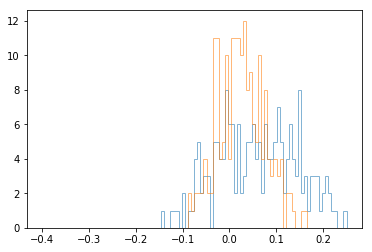

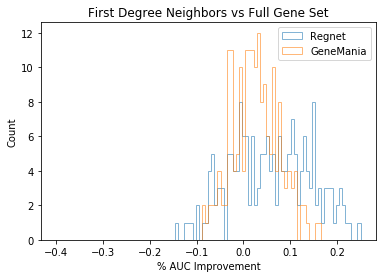

In [48]:

l1 = genemania_df['mean']
l2 = regnet_df['mean']

fig, ax = plt.subplots()
n1, bins1, patches1 = ax.hist(l1, range=(-.4, .25), bins=100, label="Regnet", density=0, alpha=0.55, histtype='step')
n1, bins1, patches1 = ax.hist(l2, range=(-.4, .25), bins=100, label="GeneMania", density=0, alpha=0.55, histtype='step')


fig, ax = plt.subplots()
n1, bins1, patches1 = ax.hist(l1, range=(-.4, .25), bins=100, label="Regnet", density=0, alpha=0.55, histtype='step')
n1, bins1, patches1 = ax.hist(l2, range=(-.4, .25), bins=100, label="GeneMania", density=0, alpha=0.55, histtype='step')

plt.title("First Degree Neighbors vs Full Gene Set")
plt.ylabel("Count")
plt.xlabel("% AUC Improvement")

plt.legend()
plt.show()